# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE): 
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$ 
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$ 
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of x_train: torch.Size([1000, 36, 36, 2])
The shape of k_train: torch.Size([1000, 36, 36, 1])
The shape of X: torch.Size([36, 36]) The shape of Y: torch.Size([36, 36])
The shape of k_train: torch.Size([1000, 36, 36, 1])
The shape of T_train: torch.Size([1000, 36, 36, 1])
The shape of k_test: torch.Size([200, 36, 36, 1])
The shape of T_test: torch.Size([200, 36, 36, 1])
The shape of kx_train: torch.Size([1000, 36, 36, 3])
The shape of kx_test: torch.Size([200, 36, 36, 3])
The shape of T_train_test: torch.Size([1000, 36, 36, 1])


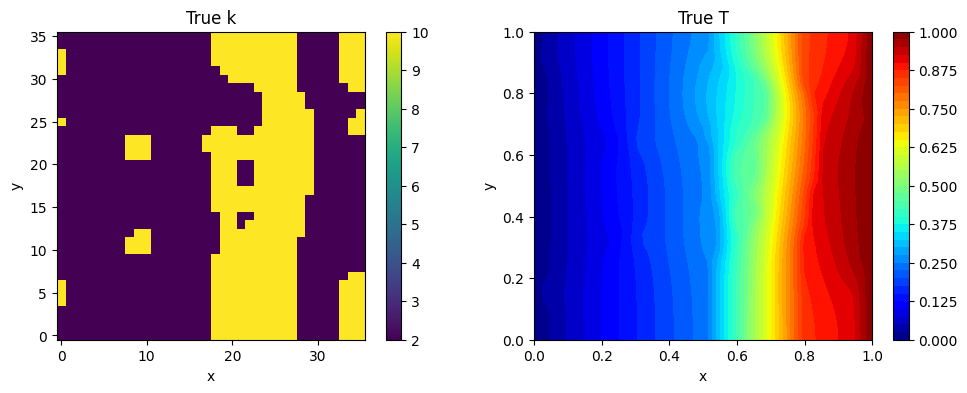

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
device = 'cuda'
dtype = torch.float32
######################################
# Load training data
######################################
res=36
ndata=1000
ntest_data=200

import os
os.chdir('/kaggle/input/dno4pdes')
######################################
with h5py.File('EffectiveConductivity.h5', 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)
    mesh = np.vstack([X.ravel(), Y.ravel()]).T
    gridx = mesh.reshape(1, res, res, 2)
    
    x_train = torch.tensor(gridx, dtype=dtype).repeat(ndata, 1, 1, 1)
    k_train=k_train.reshape(ndata, res, res, -1)
    T_train=T_train.reshape(ndata, res, res, -1)
    kx_train=torch.cat([k_train, x_train], dim=-1)
    
    
    k_test = k_test.reshape(ntest_data,res,res,-1)
    T_test = T_test.reshape(ntest_data,res,res,-1)
    x_test=torch.tensor(gridx, dtype=dtype).repeat(ntest_data, 1, 1, 1)
    kx_test=torch.cat([k_test,x_test],dim=-1)


#kx_train = torch.cat([k_train, x_train], dim=-1)
print('The shape of x_train:', x_train.shape)    
print('The shape of k_train:', k_train.shape)  
print('The shape of X:', X.shape, 'The shape of Y:', Y.shape)
print('The shape of k_train:', k_train.shape)
print('The shape of T_train:', T_train.shape)
print('The shape of k_test:', k_test.shape)
print('The shape of T_test:', T_test.shape)
print('The shape of kx_train:', kx_train.shape)
print('The shape of kx_test:', kx_test.shape)
print('The shape of T_train_test:', T_train.shape)

####### Visualize the training data 
k_show, T_show = k_train[0], T_train[0].squeeze()
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()


In [9]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()
        '''2D Fourier layer: FFT -> linear transform -> Inverse FFT
        '''
        self.in_size = in_size 
        self.out_size = out_size 
        self.modes1 = modes1
        self.modes2 = modes2 
        #
        self.scale = 1./(in_size * out_size)
        #
        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64 
        elif (dtype==torch.float64):
            ctype = torch.complex128 
        else:
            raise TypeError(f'No such data type.')
        #
        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                            modes1, modes2, 
                                                            dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                            modes1, modes2, 
                                                            dtype=ctype))
    
    def compl_mul_2d(self, input, weights):
        '''Complex multiplication: (batch_size, in_size, m1, m2) * (in_size, out_size, m1, m2) -> (batch_size, out_size, m1, m2)
        '''
        return torch.einsum('bixy,ioxy->boxy', input, weights)

    def forward(self, x):
        '''
        Input:
            x: size(batch_size, in_size, my_size, mx_size)
        Return:
            x: size(batch_size, out_size, my_size, mx_size)
        '''
        batch_size = x.shape[0]
        ####################### Compute Fourier coefficients up to factor of e^{-c}
        x_ft = torch.fft.rfft2(x) # size(batch_size, in_size, mx_size, my_size//2+1)   do: F part 
        #use rfft2 instead of fft2 to cut redundant features
        ######################## Multiply relevant Fourier modes (this part cutting the mode in 1:dir x and 2:dir y direction)
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1, 
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)
        ######################### Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1))) # size(batch_size, out_size, mx_size, my_size)

        return x 
        
class FNO2d(nn.Module):

    def __init__(self, in_size:int, out_size:int, modes1:int, modes2:int, 
                 hidden_list:list[int], dtype=None):
        super(FNO2d, self).__init__()
        self.hidden_list = hidden_list
        # Activation
        self.activation = nn.ReLU()
        # The input layer:   "Lifting part"
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)
        # The hidden layer   "FNO layers"  
        conv_net, w_net = [], []   # conv:FRF-1 net w:W net
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list:
            conv_net.append(SpectralConv2d(self.hidden_in, hidden, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(self.hidden_in, hidden, 1, dtype=dtype))  # wnet works here
            self.hidden_in =  hidden 
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)
        # The output layer
        self.fc_out0 = nn.Linear(self.hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)  #transform it into the target size
    
    def forward(self, kx):
        '''
        Input: 
            kx: size(batch_size, my_size, mx_size, k_size+x_size)
        Output: 
            T: size(batch_size, my_size, mx_size, out_size)
        '''
        batch_size = kx.shape[0]
        #print(batch_size)
        mx_size, my_size = kx.shape[1], kx.shape[2]
        #print(mx_size)
        #print(my_size)
        # The input layer: size(b, mx_size, my_size, in_size) -> (b, hidden_size, my_size, mx_size)
        kx = self.fc_in(kx)
        #print(ax.shape)
        kx = kx.permute(0, 3, 1, 2)
        # The spectral conv layer 
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            kx1 = conv(kx)   # size(b, hidden_size, my_size, mx_size)
            kx2 = weight(kx.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            kx = self.activation(kx1+kx2)
        # The output layer: size(batch_size, hidden_size, my_size, mx_size) -> size(batch_size, my_size, mx_size, out_size)
        kx = kx.permute(0, 2, 3, 1)
        kx = self.fc_out0(kx)
        kx = self.activation(kx)

        return self.fc_out1(kx)
#
mode1, mode2 = 8, 8   #select the box(region of the mode) as long as the combined size don't over the overall region  1d case: 1 mode. 2d case: 2 modes 3d case: 3 modes
hidden_list = [40, 40, 40]
model_T = FNO2d(kx_train.shape[-1], T_train.shape[-1], mode1, mode2, hidden_list).to(device)
################## Find total trainable parameters
total_trainable_params = sum(p.numel() for p in model_T.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

624,857 training parameters.


In [3]:
class LossClass(object):

    def __init__(self, T_model):
        self.device = device
        self.T_model = T_model 
    
    def loss_data(self, ax_batch, u_batch):
        '''loss term'''
        batch_size = T_batch.shape[0]
        kx, T = kx_batch.to(self.device), T_batch.to(self.device)
        #
        T_pred = self.T_model(kx)
        loss = torch.norm(T.reshape(batch_size, -1)-T_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)
        
        return loss 
    def get_error(self, kx_test, T_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        kx_test=kx_test.to(self.device)
        T = T_test.to(self.device)
        
        T_pred = self.T_model(kx_test)
        l2_err=torch.norm(T.reshape(ntest_data,-1)-T_pred.reshape(ntest_data,-1), 2, 1) / torch.norm(T.reshape(ntest_data, -1), 2, 1)
        
        return torch.mean(l2_err)

In [4]:
from torch.utils.data import Dataset, DataLoader
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, kx:torch.tensor, T:torch.tensor):
        '''
        Input:
            kx: size(batch_size, k_size+x_size)
            T: size(batch_size, T_size)
        '''
        self.kx = kx
        self.T = T
    
    def __getitem__(self, index):
        return self.kx[index], self.T[index]

    def __len__(self):
        return self.kx.shape[0]
        
##############
train_loader = DataLoader(MyDataset(kx_train, T_train), batch_size=100, shuffle=True)
for kx_batch, T_batch in train_loader:
    print('kx_batch shape:', kx_batch.shape, 'T_batch shape:', T_batch.shape)

kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])
kx_batch shape: torch.Size([100, 36, 36, 3]) T_batch shape: torch.Size([100, 36, 36, 1])


In [10]:
from tqdm import trange
import time
############ Training setups
epochs = 500
lr = 1e-3
optimizer = torch.optim.Adam(params=model_T.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list = []
error_list = []
############ The training process
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for kx_batch, T_batch in train_loader:
        lossClass = LossClass(model_T)
        loss_train = lossClass.loss_data(kx_batch, T_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    loss = loss/len(train_loader)
    loss_list.append(loss.item())

    with torch.no_grad():
        error = lossClass.get_error(kx_test, T_test)
        error_list.append(error.item())

    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
print('The consuming time is:', time.time()-t0)

 20%|██        | 100/500 [00:36<02:27,  2.71it/s]

Epoch:99, The loss is:0.23088259994983673


 40%|████      | 200/500 [01:13<01:51,  2.68it/s]

Epoch:199, The loss is:0.17311511933803558


 60%|██████    | 300/500 [01:51<01:14,  2.68it/s]

Epoch:299, The loss is:0.13095448911190033


 80%|████████  | 400/500 [02:28<00:37,  2.69it/s]

Epoch:399, The loss is:0.12026077508926392


100%|██████████| 500/500 [03:05<00:00,  2.69it/s]

Epoch:499, The loss is:0.11740349978208542
The consuming time is: 185.89480829238892


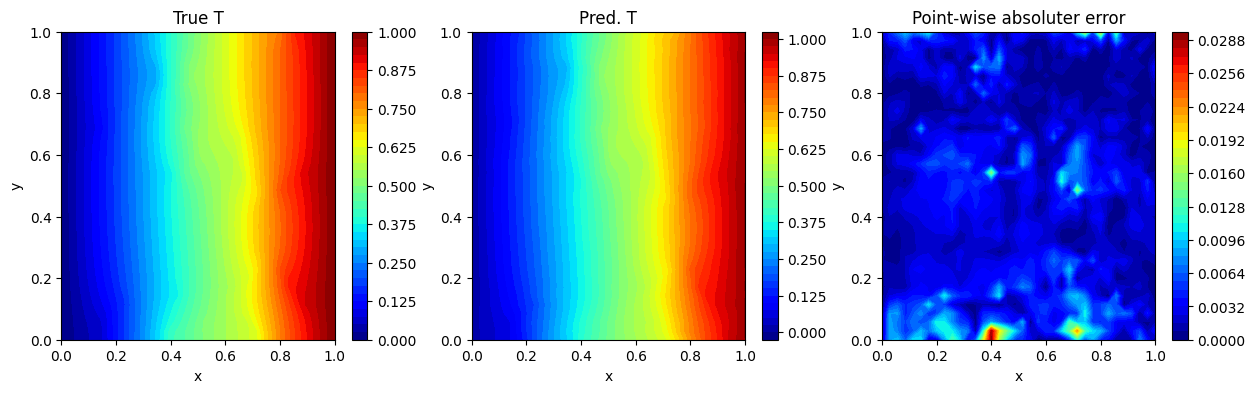

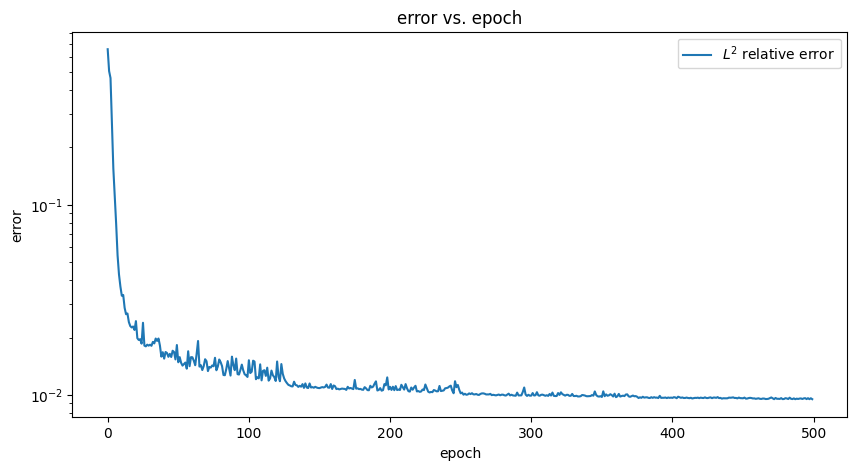

The final $L^2$ relative error is:0.009473895654082298


In [12]:
T_test_pred = model_T(kx_test.to(device)).detach().cpu()

#######################################
# Visualize the prediction and truth u
#######################################
T_true, T_pred = T_test[10].squeeze(), T_test_pred[10].squeeze()
#

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#
cntr0 = axs.flat[:][0].contourf(X, Y, T_true, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True T')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_pred, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('Pred. T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
cntr2 = axs.flat[:][2].contourf(X,Y,np.abs((T_true-T_pred).detach().numpy()), levels=40, cmap='jet')
fig.colorbar(cntr2, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absoluter error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#
plt.show()


fig,ax=plt.subplots(1,1, figsize=(10,5))
ax.semilogy(error_list, label='$L^2$ relative error')
ax.set_title('error vs. epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

plt.show()

print(f'The final $L^2$ relative error is:{error}')